<a href="https://colab.research.google.com/github/joshmuhu/computer_vision/blob/main/Banana_Crop_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this practical examination you will complete a significant project in computer vision that uses material that you learned in the course. The goal of this project is to perform banana crop detection from a set of garden images.

We follow a set of step for this classification
1. Images are changed into grayscale
2. For each image, generate its feature descriptor while using SIFT
3. Stack the features vertically to create a NumPy array (feature array)
4. Perform k-means clustering on the feature array to obtain the centers of the centroid.
5. Uses the centers obtained to perform a bag of features. This assigns the features which are similar to a specific cluster.
6. Split the dataset formed at step 5 into train and test sets at an 80:20 ratio respectively.
7. Apply the SVM and Naive Bayes for each threshold needed for the SIFT until you obtain a good classification.
8. Evaluate the classifications using accuracy, precision, recall, F1



 

In [ ]:
# mounting the drive to read the files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importing necessary libraries
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import glob
import matplotlib.pyplot as plt
from skimage import io
import PIL
import PIL.Image
from skimage import filters
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import time

In [ ]:
# reading cropped images from Banana and cassava
import pathlib
data = pathlib.Path('/content/drive/MyDrive/cvision_dataset/annotations/Banana') 
banana_images = list(data.glob('*.jpg'))
data = pathlib.Path('/content/drive/MyDrive/cvision_dataset/annotations/Cassava') 
cassava_images = list(data.glob('*.jpg'))
# print(len(known_images))

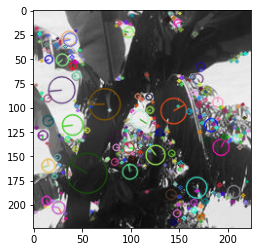

In [ ]:
# using SIFT to extract features
img = cv2.imread(str(banana_images[0]))
sift = cv2.xfeatures2d.SIFT_create()
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
kp = sift.detect(gray, None)
 
# Marking the keypoint on the image using circles
sift_img=cv2.drawKeypoints(gray ,
                      kp ,
                      img ,
                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(sift_img)

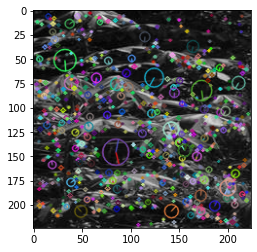

In [ ]:
# using SIFT to extract features for cassava
img = cv2.imread(str(cassava_images[0]))
sift = cv2.xfeatures2d.SIFT_create()
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
kp = sift.detect(gray, None)
 
# Marking the keypoint on the image using circles
sift_img=cv2.drawKeypoints(gray ,
                      kp ,
                      img ,
                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(sift_img)

In [ ]:
# getting features for different thresholds
def get_k_shift_thresh(thresh):
  def CalcFeatures(img, th):
    sift = cv2.xfeatures2d.SIFT_create(th)
    kp, des = sift.detectAndCompute(img, None)
    return des
  
  features = []
  for file in banana_images:
    img = cv2.imread(str(file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_des = CalcFeatures(img, thresh)
    if img_des is not None:
      features.append(img_des)
  for file in cassava_images:
    img = cv2.imread(str(file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_des = CalcFeatures(img, thresh)
    if img_des is not None:
      features.append(img_des)
  features = np.vstack(features)

  return features  

In [ ]:
# getting the features per threshold
features_per_threshold = {}
for i in range(5,26,5):
  features_per_threshold[i] = get_k_shift_thresh(i)

[[  7.   0.   0. ...   0.   1.  47.]
 [  6.  17.  51. ...   0.   0.   0.]
 [  3.   1.   0. ...   9.  67. 130.]
 ...
 [ 60.  18.   0. ...  11.  31.  20.]
 [ 37.   2.   1. ...   1.   0.   2.]
 [  2.   0.   4. ...   3.   3.   3.]]


**Method structure**
Combining all the above steps into one main algorithim

In [ ]:
def sift_svm_naive_classifier(thresh):

  t0 = time.time()

  def CalcFeatures(img, th):
    sift = cv2.xfeatures2d.SIFT_create(th)
    kp, des = sift.detectAndCompute(img, None)
    return des
  
  '''
  All the files appended to the image_path list are passed through the
  CalcFeatures functions which returns the descriptors which are 
  appended to the features list and then stacked vertically in the form
  of a numpy array.
  '''

  features = []
  for file in banana_images:
    img = cv2.imread(str(file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_des = CalcFeatures(img, thresh)
    if img_des is not None:
      features.append(img_des)
  for file in cassava_images:
    img = cv2.imread(str(file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_des = CalcFeatures(img, thresh)
    if img_des is not None:
      features.append(img_des)
  features = np.vstack(features)

  '''
  K-Means clustering is then performed on the feature array obtained 
  from the previous step. The centres obtained after clustering are 
  further used for bagging of features.
  '''

  k = 150
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.1)
  flags = cv2.KMEANS_RANDOM_CENTERS
  compactness, labels, centres = cv2.kmeans(features, k, None, criteria, 10, flags)

  '''
  The bag_of_features function assigns the features which are similar
  to a specific cluster centre thus forming a Bag of Words approach.  
  '''

  def bag_of_features(features, centres, k = 500):
      vec = np.zeros((1, k))
      for i in range(features.shape[0]):
          feat = features[i]
          diff = np.tile(feat, (k, 1)) - centres
          dist = pow(((pow(diff, 2)).sum(axis = 1)), 0.5)
          idx_dist = dist.argsort()
          idx = idx_dist[0]
          vec[0][idx] += 1
      return vec

  labels = []
  vec = []
  for file in banana_images:
    img = cv2.imread(str(file))
    img_des = CalcFeatures(img, thresh)
    if img_des is not None:
      img_vec = bag_of_features(img_des, centres, k)
      vec.append(img_vec)
      labels.append(0)
  for file in cassava_images:
    img = cv2.imread(str(file))
    img_des = CalcFeatures(img, thresh)
    if img_des is not None:
      img_vec = bag_of_features(img_des, centres, k)
      vec.append(img_vec)
      labels.append(1)
  vec = np.vstack(vec)

  '''
  Splitting the data formed into test and split data and training the 
  SVM Classifier.
  '''

  X_train, X_test, y_train, y_test = train_test_split(vec, labels, test_size=0.2)
  clf = SVC()
  clf.fit(X_train, y_train)
  preds = clf.predict(X_test)
  acc = accuracy_score(y_test, preds)
  conf_mat = confusion_matrix(y_test, preds)
  # plt.imshow(conf_mat, cmap='binary')

  clf_g = GaussianNB()
  clf_g.fit(X_train, y_train)
  preds_g = clf_g.predict(X_test)
  acc_g = accuracy_score(y_test, preds_g)
  conf_mat_g = confusion_matrix(y_test, preds_g)
  

  t1 = time.time()
  
  return acc*100, conf_mat, (t1-t0), acc_g*100, conf_mat_g


accuracy = {}
accuracy_g = {}
conf_mat_lst = {}
conf_mat_lst_g = {}
timer = []
# data_analysis = {}
for i in range(5,26,5):
  print('\nCalculating for a threshold of {}'.format(i))
  data = sift_svm_naive_classifier(i)
  # accuracy.append(data[0])
  accuracy[i] = data[0]
  accuracy_g[i] = data[3]
  conf_mat = data[1]
  conf_mat_lst[i] = data[1]
  conf_mat_lst_g[i] = data[4]
  timer.append(data[2])
  print('\nSVM\nAccuracy = {}\nTime taken = {} sec\nConfusion matrix :\n{}'.format(data[0],data[2],data[1]))
  print('\nGausian\nAccuracy = {}\nTime taken = {} sec\nConfusion matrix :\n{}'.format(data[3],data[2],data[4]))


Calculating for a threshold of 5

SVM
Accuracy = 97.84946236559139
Time taken = 58.556357860565186 sec
Confusion matrix :
[[120   5]
 [  1 153]]

Gausian
Accuracy = 78.85304659498208
Time taken = 58.556357860565186 sec
Confusion matrix :
[[ 66  59]
 [  0 154]]

Calculating for a threshold of 10

SVM
Accuracy = 99.2831541218638
Time taken = 65.34522557258606 sec
Confusion matrix :
[[118   2]
 [  0 159]]

Gausian
Accuracy = 95.6989247311828
Time taken = 65.34522557258606 sec
Confusion matrix :
[[119   1]
 [ 11 148]]

Calculating for a threshold of 15

SVM
Accuracy = 98.9247311827957
Time taken = 65.6325376033783 sec
Confusion matrix :
[[112   2]
 [  1 164]]

Gausian
Accuracy = 75.26881720430107
Time taken = 65.6325376033783 sec
Confusion matrix :
[[ 45  69]
 [  0 165]]

Calculating for a threshold of 20

SVM
Accuracy = 100.0
Time taken = 70.02526473999023 sec
Confusion matrix :
[[103   0]
 [  0 176]]

Gausian
Accuracy = 98.56630824372759
Time taken = 70.02526473999023 sec
Confusion matr

In [ ]:
sum(accuracy.values())/len(accuracy.values())

99.13978494623657

In [ ]:
sum(accuracy_g.values())/len(accuracy_g.values())


84.51612903225806

In [ ]:
conf_mat_lst

{5: array([[120,   5],
        [  1, 153]]), 10: array([[118,   2],
        [  0, 159]]), 15: array([[112,   2],
        [  1, 164]]), 20: array([[103,   0],
        [  0, 176]]), 25: array([[116,   0],
        [  1, 162]])}

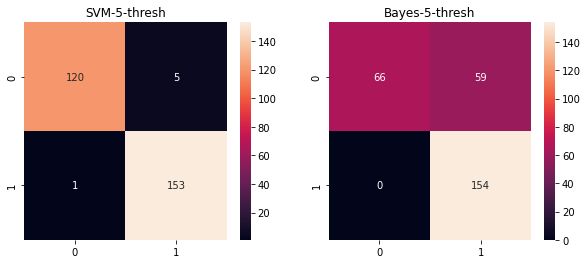

In [ ]:
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 4))
sns.heatmap(conf_mat_lst[5], annot=True, fmt='g',ax=ax1)
sns.heatmap(conf_mat_lst_g[5], annot=True, fmt='g',ax=ax2)
ax1.set_title('SVM-5-thresh')
ax2.set_title('Bayes-5-thresh')
plt.show()

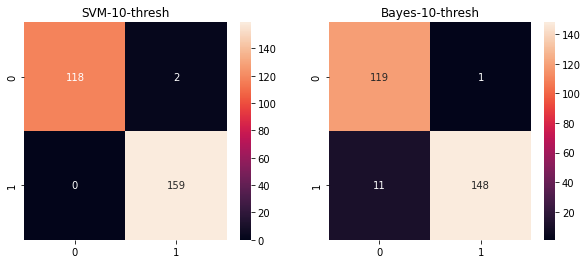

In [ ]:
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 4))
sns.heatmap(conf_mat_lst[10], annot=True, fmt='g',ax=ax1)
sns.heatmap(conf_mat_lst_g[10], annot=True, fmt='g',ax=ax2)
ax1.set_title('SVM-10-thresh')
ax2.set_title('Bayes-10-thresh')
plt.show()

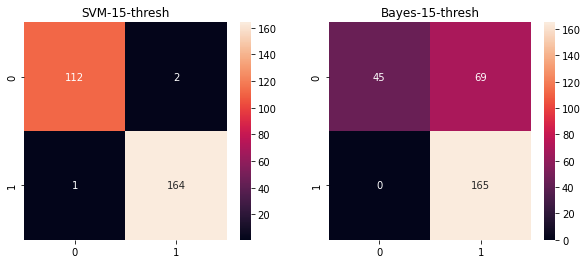

In [ ]:
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 4))
sns.heatmap(conf_mat_lst[15], annot=True, fmt='g',ax=ax1)
sns.heatmap(conf_mat_lst_g[15], annot=True, fmt='g',ax=ax2)
ax1.set_title('SVM-15-thresh')
ax2.set_title('Bayes-15-thresh')
plt.show()

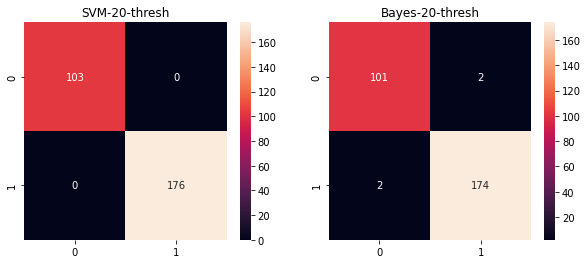

In [ ]:
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 4))
sns.heatmap(conf_mat_lst[20], annot=True, fmt='g',ax=ax1)
sns.heatmap(conf_mat_lst_g[20], annot=True, fmt='g',ax=ax2)
ax1.set_title('SVM-20-thresh')
ax2.set_title('Bayes-20-thresh')
plt.show()

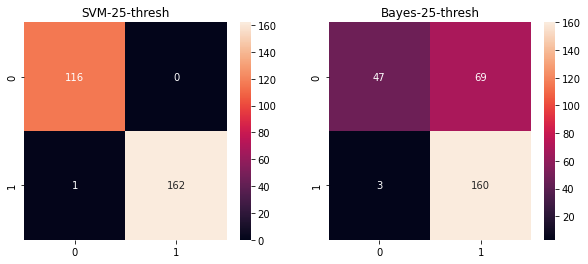

In [ ]:
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 4))
sns.heatmap(conf_mat_lst[25], annot=True, fmt='g',ax=ax1)
sns.heatmap(conf_mat_lst_g[25], annot=True, fmt='g',ax=ax2)
ax1.set_title('SVM-25-thresh')
ax2.set_title('Bayes-25-thresh')
plt.show()

In [ ]:
# comparing there accuracys
import pandas as pd
combined_dict = {"svm":accuracy, "bayes":accuracy_g}
combined_dict
df = pd.DataFrame(combined_dict)
df

,svm,bayes
5,97.849462,78.853047
10,99.283154,95.698925
15,98.924731,75.268817
20,100.000000,98.566308
25,99.641577,74.193548


In [ ]:
from sklearn.naive_bayes import GaussianNB

Text(0.5, 0, 'SIFT-Threshold')

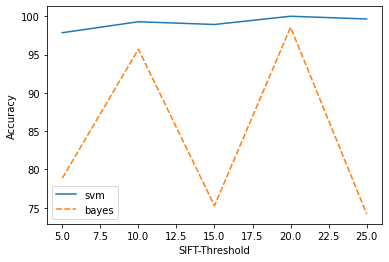

In [ ]:
plot = sns.lineplot(data=df)
plot.set_ylabel("Accuracy")
plot.set_xlabel("SIFT-Threshold")
